# Galerkin Approach

Before moving to more difficult differential equations, consider just the following trivial equation

$$
f(x) \approx u(x)
$$

Through the finite element method, we try to approximate $f$ through the approximation $u$, which is a sum of $N$ different prescribed functions $\psi_i(x)$ and unknown coefficients $c_i$:

$$
u(x) = \sum_{i=0}^N c_i \psi_i(x)
$$

## Approximation of Vectors
Consider that $\mathbf{f} = (f_1, f_2)$ is a vector. Let's try to approximate it through  another vector $\mathbf{u}$, which is aligned in the direction of an arbitrary basis $\mathbf{\psi}_0 = (e_1, e_2)$ the vector space $V$.

### Aim
Find the vector $\mathbf{u} = c_0 \mathbf{\psi}_0 \in V$ that is the best approximation to the vector $\mathbf{f}$.

### Criterion
Minimize the length of the difference between approximation $\mathbf{u}$ and solution $\mathbf{f}$.
Herefore, the error $\mathbf{e} = \mathbf{f} - \mathbf{u}$ is introduced, whose length is defined through
$$
||\mathbf{e}|| = (\mathbf{e} \cdot \mathbf{e})^{1/2}
$$

with the inner product 
$$(\mathbf{x} \cdot \mathbf{y}) = \sum_{i=0}^{N} x_i y_i$$

#### The least squares method
In order to minimize $||\mathbf{e}||$ and thereby find $c_0$, which gives the best approximation of $\mathbf{u}$ to $\mathbf{f}$, we introduce the function
$$
E(c_0) = (\mathbf{e} \cdot \mathbf{e}) 
= \left((\mathbf{f} - c_0 \mathbf{\psi}_0) \cdot (\mathbf{f} - c_0 \mathbf{\psi}_0) \right)
= (\mathbf{f} \cdot \mathbf{f}) - 2 c_0 (\mathbf{f} \cdot \mathbf{\psi}_0) 
+ c_0^2 (\mathbf{\psi}_0 \cdot \mathbf{\psi}_0).
$$

To find the optimum value of $c_0$, we have to set the derivative of $E(c_0)$ for $c_0$ to zero:
$$
\frac{\partial E(c_0)}{\partial c_0} = 0 
$$

In this case, this reduces to the following equation:

$$
\frac{\partial E(c_0)}{\partial c_0} = 
- 2 (\mathbf{f} \cdot \mathbf{\psi}_0) 
+ 2 c_0 (\mathbf{\psi}_0 \cdot \mathbf{\psi}_0)
= 0
$$
which can also be written as
$$
\left( (\mathbf{f}- c_0 \mathbf{\psi}_0) \cdot \mathbf{\psi}_0\right) = 0
$$
or 
$$
(\mathbf{e} \cdot \mathbf{\psi}_0 ) = 0
$$

This can be solved for $c_0$:
$$c_0 = \frac{(\mathbf{f} \cdot \mathbf{\psi}_0) }{(\mathbf{\psi}_0 \cdot \mathbf{\psi}_0)}
$$

In [ ]:
from matplotlib import pyplot as plt

(f_1, f_2) = (3, 4)



[-1.0706817  -0.23112637 -0.22962645 -0.15494506 -0.12769095 -0.10558575
 -0.09066567 -0.07929121 -0.07048563 -0.06343343 -0.05766571]


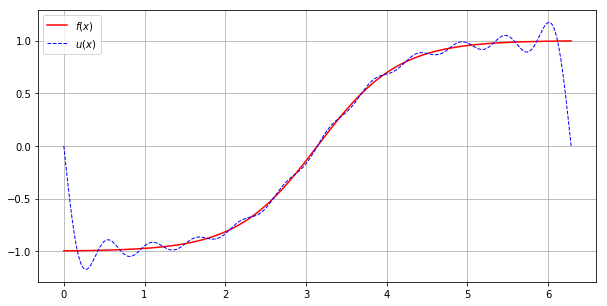

In [91]:
import numpy as np


def least_squares_numerical(f, psi, N, x, 
                            integration_method='scipy',
                            orthogonal_basis=False):
    import scipy.integrate
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)
    # Integration range
    Omega = [x[0], x[-1]]
    dx = x[1] - x[0]
    
    for i in range(0, N+1):
        
        # Compute entries of matrix A
        j_limit = i+1 if orthogonal_basis else N+1
        for j in range(i, j_limit):
            if (integration_method == 'scipy'):
                A_ij = scipy.integrate.quad(
                        lambda x: psi(x,i) * psi(x,j),
                        Omega[0], Omega[1], epsabs=1e-9, epsrel=1e-9)[0]
            else:
                values = psi(x,i) * psi(x,j)
                A_ij = trapezoidal(values, dx)
                
            A[i][j] = A[j][i] = A_ij
            
        # compute entries of rhs b
        if (integration_method == 'scipy'):
            b_i = scipy.integrate.quad(
                    lambda x: f(x)*psi(x,i),
                    Omega[0], Omega[1], epsabs=1e-9, epsrel=1e-9)[0]
        else:
            values = psi(x,i) * f(x)
            b_i = trapezoidal(values, dx)
        b[i] = b_i
        
    c = b / np.diag(A) if orthogonal_basis else np.linalg.solve(A, b)
    u  = sum(c[i]*psi(x, i) for i in range(0, N+1))
    return u, c

def trapezoidal(values, dx):
    """Integrate values by trapezoidal rule"""
    return dx*(np.sum(values) - 0.5*values[0] - 0.5*values[-1])





from numpy import linspace, tanh, pi, sin

def psi(x, i):
    return sin((i+1)*x)
    #return x**i
    
x = linspace(0, 2*pi, 501)
N = 10
f = lambda x: tanh(x-pi)
#f = lambda x: 10. * (x-1.)**2 - 1


u, c = least_squares_numerical(f, psi, N, x, 
                               integration_method='scipy',
                               orthogonal_basis=True)

print(c)


from matplotlib import pyplot as plt

fig = plt.figure()
fig.set_size_inches(10,5)
ax = fig.add_subplot(111)

f_plt = ax.plot(x, f(x), c='r', lw=1.5, ls='-', label=r'$f(x)$')
u_plt = ax.plot(x, u, c='b', lw=1.0, ls='--', label=r'$u(x)$')

legend = plt.legend()

ax.grid(True)

plt.show()

# Using Lagrange Polynomials

In [104]:
''' Compute lagrangian interpolation polynomial over domain x at specific points '''
def Lagrange_polynomial(x, i, points):
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

def Chebyshev_nodes(a, b, N):
    from math import cos, pi
    return [0.5*(a+b) + 0.5*(b-a)*cos((2.*i+1.)/(2.*(N+1.))*pi) for i in range(N+1)]


''' Compute complete basis of lagrange polynomials at specified points '''
def Lagrange_polynomials_01(x, N, Omega, point_distribution='uniform'):
    if point_distribution == 'uniform':
        h = 1.0 / (N-1)
        points = [i*h for i in range(N+1)]

    elif point_distribution == 'Chebyshev':
        points = Chebyshev_nodes(Omega[0], Omega[1], N)
        
    psi = [Lagrange_polynomial(x, i, points) for i in range(N)]
    return psi, points


x = np.linspace(0,1,10)
psi, points = Lagrange_polynomials_01(x, 
                                      Omega=(0,1), 
                                      N=3, 
                                      point_distribution='Chebyshev')

print(points)

[0.9619397662556434, 0.6913417161825449, 0.30865828381745514, 0.03806023374435663]


# Finite Element Introduction

In [106]:
# Defining the mesh
nodes = [0, 0.2, 0.4, 0.7, 1.0]
elements = [[0,1,2],[2,3,4]]

